### Student Information
Name:

Student ID: 107041033

GitHub ID: LiChiLin

Kaggle name: leechilin

Kaggle private scoreboard snapshot:

[Snapshot](img/pic0.png)

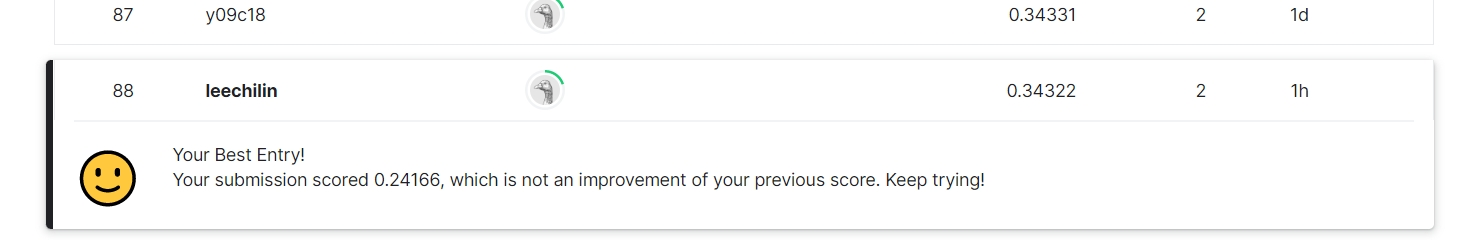

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home** exercises in the [DM2022-Lab2-master Repo](https://github.com/keziatamus/DM2022-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm2022-isa5810-lab2-homework) regarding Emotion Recognition on Twitter by this link https://www.kaggle.com/t/2b0d14a829f340bc88d2660dc602d4bd. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (60-x)/6 + 20 points, where x is your ranking in the leaderboard (ie. If you rank 3rd your score will be (60-3)/6 + 20 = 29.5% out of 30%)   
    Submit your last submission __BEFORE the deadline (Nov. 22th 11:59 pm, Tuesday)_. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developping the model for the competition (You can use code and comment it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook** and **add minimal comments where needed**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 25th 11:59 pm, Friday)__. 

---
## 1. Data Preparation

Before beggining the lab, please make sure to download the [Google News Dataset](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit) and place it in a folder named "GoogleNews" in the same directory as this file.

## 1.1 Load data

We start by loading the csv files into a single pandas dataframe for training and one for testing.

In [1]:
### Begin Assignment Here
import pandas as pd
### load csv data
data_id = pd.read_csv("data_identification.csv") #, index_col='tweet_id')
emotion = pd.read_csv("emotion.csv")#, index_col='tweet_id')
tweets = pd.read_json("tweets_DM.json", lines=True)


In [2]:
tweets

,_score,_index,_source,_crawldate,_type
0,391,hashtag_tweets,"{'tweet': {'hashtags': ['Snapchat'], 'tweet_id...",2015-05-23 11:42:47,tweets
1,433,hashtag_tweets,"{'tweet': {'hashtags': ['freepress', 'TrumpLeg...",2016-01-28 04:52:09,tweets
2,232,hashtag_tweets,"{'tweet': {'hashtags': ['bibleverse'], 'tweet_...",2017-12-25 04:39:20,tweets
3,376,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x1cd5...",2016-01-24 23:53:05,tweets
4,989,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x2de2...",2016-01-08 17:18:59,tweets
...,...,...,...,...,...
1867530,827,hashtag_tweets,"{'tweet': {'hashtags': ['mixedfeeling', 'butim...",2015-05-12 12:51:52,tweets
1867531,368,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x29d0...",2017-10-02 17:54:04,tweets
1867532,498,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x2a6a...",2016-10-10 11:04:32,tweets
1867533,840,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x24fa...",2016-09-02 14:25:06,tweets


In [3]:
tweet_id = [tweets['_source'][i]['tweet']['tweet_id'] for i in range(len(tweets['_source']))]
tweet_text = [tweets['_source'][i]['tweet']['text'] for i in range(len(tweets['_source']))]
tweet = pd.DataFrame({'tweet_id': tweet_id, 'text': tweet_text})

In [4]:
### concatenate dfs to one df by tweet_id
df = data_id.merge(emotion, on='tweet_id', how='outer').merge(tweet, on='tweet_id', how='outer')
df.shape
### train-test split
train_df = df[df['identification']=='train']
test_df = df[df['identification']=='test']

In [5]:
# shuffle dataset
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)

In [6]:
print("Shape of Training df: ", train_df.shape)
print("Shape of Testing df: ", test_df.shape)

Shape of Training df:  (1455563, 4)
Shape of Testing df:  (411972, 4)


---
### 1.2 Save data

We will save our data in Pickle format. The pickle module implements binary protocols for serializing and de-serializing a Python object structure.   
  
Some advantages for using pickle structure:  
* Because it stores the attribute type, it's more convenient for cross-platform use.  
* When your data is huge, it could use less space to store also consume less loading time.   

In [7]:
## save to pickle file
train_df.to_pickle("./train_df.pkl") 
test_df.to_pickle("./test_df.pkl")

---
### 1.3 Exploratory data analysis (EDA)

Again, before getting our hands dirty, we need to explore a little bit and understand the data we're dealing with.

In [8]:
# group to find distribution
train_df.groupby(['emotion']).count()['text']

emotion
anger            39867
anticipation    248935
disgust         139101
fear             63999
joy             516017
sadness         193437
surprise         48729
trust           205478
Name: text, dtype: int64

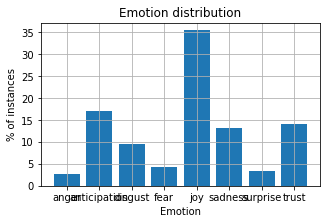

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# the histogram of the data
labels = train_df['emotion'].unique()
post_total = len(train_df)
df1 = train_df.groupby(['emotion']).count()['text']
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(5,3))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.grid(True)
plt.show()

## 2. Feature engineering
### Using Bag of Words
Using scikit-learn ```CountVectorizer``` perform word frequency and use these as features to train a model.  
http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
# build analyzers (bag-of-words)
BOW_vectorizer = CountVectorizer() 
# 1. Learn a vocabulary dictionary of all tokens in the raw documents.
BOW_vectorizer.fit(train_df['text'])

# 2. Transform documents to document-term matrix.
train_data_BOW_features = BOW_vectorizer.transform(train_df['text'])
test_data_BOW_features = BOW_vectorizer.transform(test_df['text'])
# check the result
train_data_BOW_features

<1455563x794247 sparse matrix of type '<class 'numpy.int64'>'
	with 18849355 stored elements in Compressed Sparse Row format>

In [11]:
import nltk

# build analyzers (bag-of-words)
BOW_500 = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize) 

# apply analyzer to training data
BOW_500.fit(train_df['text'])

train_data_BOW_features_500 = BOW_500.transform(train_df['text'])

## check dimension
train_data_BOW_features_500.shape

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


(1455563, 500)

---
## 3. Model
### 3.1 Decision Trees
Using scikit-learn ```DecisionTreeClassifier``` performs word frequency and uses these as features to train a model.  
http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# for a classificaiton problem, you need to provide both training & testing data
X_train = BOW_500.transform(train_df['text'])
y_train = train_df['emotion']

X_test = BOW_500.transform(test_df['text'])
y_test = test_df['emotion']

## take a look at data dimension is a good habit  :)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

In [ ]:
## build DecisionTree model
DT_model = DecisionTreeClassifier(random_state=1)

## training!
DT_model = DT_model.fit(X_train, y_train)

## predict!
y_train_pred = DT_model.predict(X_train)
y_test_pred = DT_model.predict(X_test)

## so we get the pred result
y_test_pred[:10]

In [ ]:
test_df['tweet_id'].shape
answer = pd.DataFrame({'id': test_df['tweet_id'], 'emotion': y_test_pred})
answer.to_csv('submission.csv', index=False) #submission.csv
pd.read_csv('./submission.csv').shape

### 3.2 Neural Network

In [27]:
## deal with label (string -> one-hot)

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import keras

X_train, X_test, y_train, y_test = train_test_split(train_df['text'], train_df['emotion'], test_size=0.33, random_state=42)

# standardize name (X, y) 
X_train = BOW_500.transform(X_train)
y_train = y_train

X_test = BOW_500.transform(X_test)
y_test = y_test

## check dimension is a good habbit 
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.np_utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_train)
y_test = label_encode(label_encoder, y_test)

print('\n\n## After convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)


X_train.shape:  (975227, 500)
y_train.shape:  (975227,)
X_test.shape:  (480336, 500)
y_test.shape:  (480336,)
check label:  ['anger' 'anticipation' 'disgust' 'fear' 'joy' 'sadness' 'surprise'
 'trust']

## Before convert
y_train[0:4]:
 814612       anger
25104        trust
846066         joy
1554215    sadness
Name: emotion, dtype: object

y_train.shape:  (975227,)
y_test.shape:  (480336,)


## After convert
y_train[0:4]:
 [[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]]

y_train.shape:  (975227, 8)
y_test.shape:  (480336, 8)


In [28]:
# I/O check
input_shape = X_train.shape[1]
print('input_shape: ', input_shape)

output_shape = len(label_encoder.classes_)
print('output_shape: ', output_shape)

input_shape:  500
output_shape:  8


In [29]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import ReLU, Softmax

# input layer
model_input = Input(shape=(input_shape, ))  # 500
X = model_input

# 1st hidden layer
X_W1 = Dense(units=256)(X)  # 64
H1 = ReLU()(X_W1)

# 2nd hidden layer
H1_W2 = Dense(units=128)(H1)  # 64
H2 = ReLU()(H1_W2)

# output layer
H2_W3 = Dense(units=output_shape)(H2)  # 4
H3 = Softmax()(H2_W3)

model_output = H3

# create model
model = Model(inputs=[model_input], outputs=[model_output])

# loss function & optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# show model construction
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               128256    
_________________________________________________________________
re_lu_2 (ReLU)               (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
re_lu_3 (ReLU)               (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 1032      
_________________________________________________________________
softmax_1 (Softmax)          (None, 8)                 0   

In [26]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('logs/training_log.csv')

# training setting
epochs = 50
batch_size = 128

# training!
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
#                     callbacks=[csv_logger],
                    validation_data = (X_test, y_test))
print('training finish')

Epoch 1/50


C:\Users\ASUS\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/dense_2/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/dense_2/embedding_lookup_sparse/Reshape:0", shape=(None, 256), dtype=float32), dense_shape=Tensor("gradient_tape/model/dense_2/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


7619/7619 [==============================] - 56s 7ms/step - loss: 1.4130 - accuracy: 0.4850 - val_loss: 1.3751 - val_accuracy: 0.4984
Epoch 2/50
7619/7619 [==============================] - 60s 8ms/step - loss: 1.3538 - accuracy: 0.5061 - val_loss: 1.3629 - val_accuracy: 0.5040
Epoch 3/50
7619/7619 [==============================] - 70s 9ms/step - loss: 1.3290 - accuracy: 0.5152 - val_loss: 1.3590 - val_accuracy: 0.5055
Epoch 4/50
7619/7619 [==============================] - 119s 15ms/step - loss: 1.3108 - accuracy: 0.5221 - val_loss: 1.3603 - val_accuracy: 0.5053
Epoch 5/50
7619/7619 [==============================] - 319s 41ms/step - loss: 1.2965 - accuracy: 0.5270 - val_loss: 1.3638 - val_accuracy: 0.5045
Epoch 6/50
7619/7619 [==============================] - 63s 8ms/step - loss: 1.2844 - accuracy: 0.5315 - val_loss: 1.3689 - val_accuracy: 0.5036
Epoch 7/50
7619/7619 [==============================] - 76s 10ms/step - loss: 1.2742 - accuracy: 0.5352 - val_loss: 1.3727 - val_accuracy

In [47]:
## predict
X_test = BOW_500.transform(test_df['text'])
# y_test = test_df['emotion']
pred_result = model.predict(X_test, batch_size=128)
pred_result = label_decode(label_encoder, pred_result)
pred_result[:5]
test_df['tweet_id'].shape
answer = pd.DataFrame({'id': test_df['tweet_id'], 'emotion': pred_result})
answer.to_csv('submission.csv', index=False) #submission.csv
pd.read_csv('./submission.csv').shape

(411972, 2)

### 3.3 LSTM

In [22]:
# Import the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()
# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 500, return_sequences = True, input_shape = (1, X_train.shape[1])))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 500, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 500, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 500))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = output_shape))

# Compiling
regressor.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 進行訓練
# regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)
# show model construction
regressor.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 1, 500)            2002000   
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 500)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 1, 500)            2002000   
_________________________________________________________________
dropout_9 (Dropout)          (None, 1, 500)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 1, 500)            2002000   
_________________________________________________________________
dropout_10 (Dropout)         (None, 1, 500)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 500)              

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import keras

X_train, X_test, y_train, y_test = train_test_split(train_df['text'], train_df['emotion'], test_size=0.33, random_state=42)

# standardize name (X, y) 
X_train = BOW_500.transform(X_train)
y_train = y_train

X_test = BOW_500.transform(X_test)
y_test = y_test

In [30]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('logs/training_log.csv')

# training setting
epochs = 100
batch_size = 128

# training!
history = regressor.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
#                     callbacks=[csv_logger],
                    validation_data = (X_test, y_test))
print('training finish')

Epoch 1/50


C:\Users\ASUS\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_1/dense_5/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_1/dense_5/embedding_lookup_sparse/Reshape:0", shape=(None, 256), dtype=float32), dense_shape=Tensor("gradient_tape/model_1/dense_5/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


7619/7619 [==============================] - 102s 13ms/step - loss: 1.4135 - accuracy: 0.4845 - val_loss: 1.3777 - val_accuracy: 0.4972
Epoch 2/50
7619/7619 [==============================] - 109s 14ms/step - loss: 1.3537 - accuracy: 0.5058 - val_loss: 1.3634 - val_accuracy: 0.5032
Epoch 3/50
7619/7619 [==============================] - 112s 15ms/step - loss: 1.3291 - accuracy: 0.5147 - val_loss: 1.3576 - val_accuracy: 0.5057
Epoch 4/50
7619/7619 [==============================] - 115s 15ms/step - loss: 1.3113 - accuracy: 0.5217 - val_loss: 1.3590 - val_accuracy: 0.5055
Epoch 5/50
7619/7619 [==============================] - 115s 15ms/step - loss: 1.2971 - accuracy: 0.5264 - val_loss: 1.3655 - val_accuracy: 0.5050
Epoch 6/50
7619/7619 [==============================] - 120s 16ms/step - loss: 1.2850 - accuracy: 0.5312 - val_loss: 1.3678 - val_accuracy: 0.5030
Epoch 7/50
7619/7619 [==============================] - 119s 15ms/step - loss: 1.2748 - accuracy: 0.5345 - val_loss: 1.3752 - val

In [31]:
## predict
X_test = BOW_500.transform(test_df['text'])
# y_test = test_df['emotion']
pred_result = model.predict(X_test, batch_size=128)
pred_result = label_decode(label_encoder, pred_result)
pred_result[:5]
test_df['tweet_id'].shape
answer = pd.DataFrame({'id': test_df['tweet_id'], 'emotion': pred_result})
answer.to_csv('submission.csv', index=False) #submission.csv
pd.read_csv('./submission.csv').shape

(411972, 2)

### 4 Report

I. Feature Engineering :

Based on the TA’s advices, I utilize the Bagofwords to preprocess the 
train data and test data. I have already compared the Bagofwords method 
and Tokenizer method, and then I found that Bagofwords have better results 
when I latter apply those methods to my model.

II. Model Building :

In this section, I am going to discuss the model I build for this 
competition. Since Decision Tree, Neural Network, and LSTM Model are 
frequently discussed in the Kaggle competition in the past, I decide to 
construct those three models to compare the final results.

1. Decision tree:
This model is much more simpler compared to the latter, so I simply set 
the random state as 1. Afterwards, I shuffle the data and start training. 
Eventually, I got the final results – approximately 0.24 score in the 
Kaggle competition.

2. Neural Networks:
The training data is quite large with exactly 500 features. Therefore, I 
build not shallow neural network to solve it. Using 500, 128, and 64 as 
connecting units and setting the activation function as ReLU. In the end, 
the output layer activation function is softmax. 
To lower the training loss, this model need about 50 epochs to reach 
higher accuracy. In addition, I utilize the adam as optimizer to boost this 
model. Eventually, I reach about 0.38 score in the Kaggle competition. 
3. LSTM:
LSTM is renowned for solving the text question in Kaggle, and lots of 
people frequently discuss this model. Hence, I decide to adopt this 
model. 
I set the units as the same with the features with training data. In 
addition, since the dimensions of that is three, so I set the 
return_sequences as true. The units are too large so I need to dropout 
20% of the data. In the end, I reach about 0.38 score in the Kaggle 
competition.
4. Conclusion:
Comparing the three model performances, I conclude that according to 
this three model performance, shallow neural networks achieve higher 
accuracy in this dataset.